# Import Packages

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from dotenv import load_dotenv   # <- helper for .env files

#Set plot style
plt.style.use("seaborn-v0_8")


# Connect to Neon DB &  Load data

In [32]:
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")
# !!!
engine = create_engine(DB_URL)

query = """
SELECT "timestamp", "part_id", "reading"
FROM "catdc_data_feed"
WHERE "state"='RUNNING';
"""

df_long = pd.read_sql(query, engine)

df_train = df_long.pivot_table(index="timestamp", columns="part_id", values="reading", aggfunc="mean")

df_train.columns = [f"Axis #{i}" for i in df_train.columns]
df_train.reset_index(inplace=True)
df_train.rename(columns={"timestamp": "Time"}, inplace=True)

# fill missing values
df_train.fillna(0, inplace=True)

#convert time to datetime

df_train["Time"] = pd.to_datetime(df_train["Time"])

# Column lists

axis_cols = [col for col in df_train.columns if col.startswith("Axis #")]
time_col = ["Time"]

# Preview first 5 rows

df_train.head()



,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-17 12:18:25.472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-17 12:18:27.348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-17 12:18:29.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-17 12:18:31.117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalize data (min-max)

In [33]:
scaler = MinMaxScaler()
df_norm = df_train.copy()
df_norm[axis_cols] = scaler.fit_transform(df_train[axis_cols])

df_norm.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-17 12:18:25.472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-17 12:18:27.348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-17 12:18:29.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-17 12:18:31.117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Standardize (Z-scores)


In [34]:
scaler_std = StandardScaler()

df_std = df_train.copy()
df_std[axis_cols] = scaler_std.fit_transform(df_train[axis_cols])

df_std.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660,-0.29611,-0.49169,-0.490623,-0.368541,-0.430555,-0.301911,-0.362789,-0.15222
1,2022-10-17 12:18:25.472,-0.29611,-0.49169,-0.490623,-0.368541,-0.430555,-0.301911,-0.362789,-0.15222
2,2022-10-17 12:18:27.348,-0.29611,-0.49169,-0.490623,-0.368541,-0.430555,-0.301911,-0.362789,-0.15222
3,2022-10-17 12:18:29.222,-0.29611,-0.49169,-0.490623,-0.368541,-0.430555,-0.301911,-0.362789,-0.15222
4,2022-10-17 12:18:31.117,-0.29611,-0.49169,-0.490623,-0.368541,-0.430555,-0.301911,-0.362789,-0.15222


# Regression Models (Time > Axis

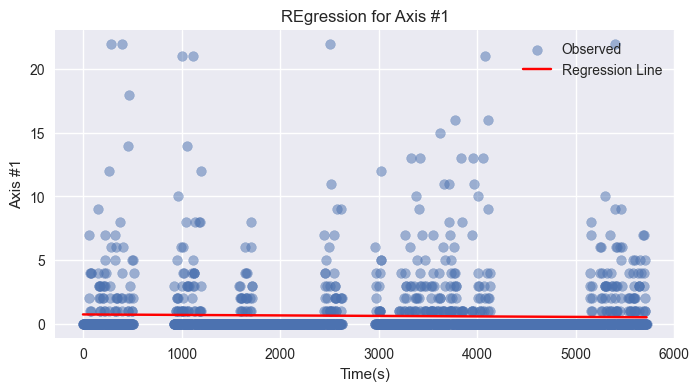

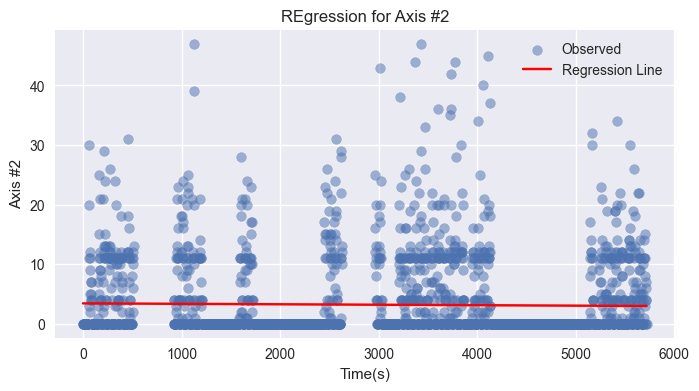

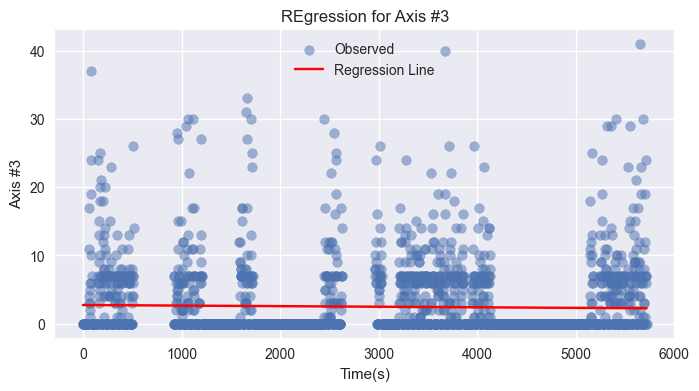

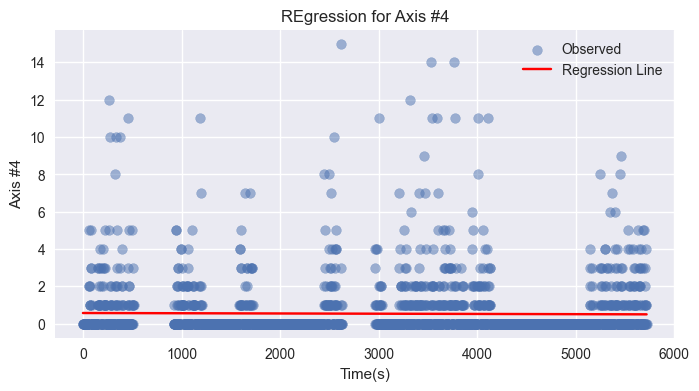

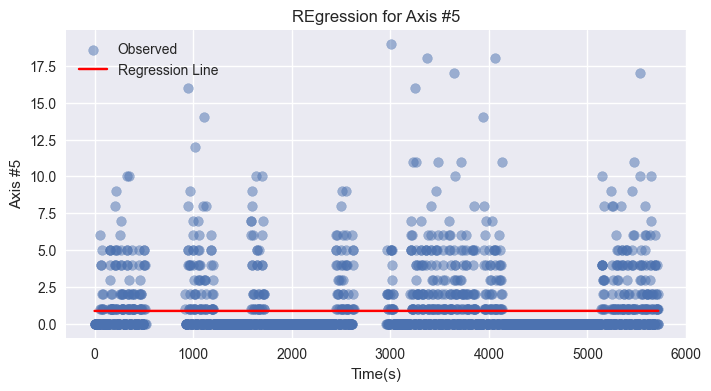

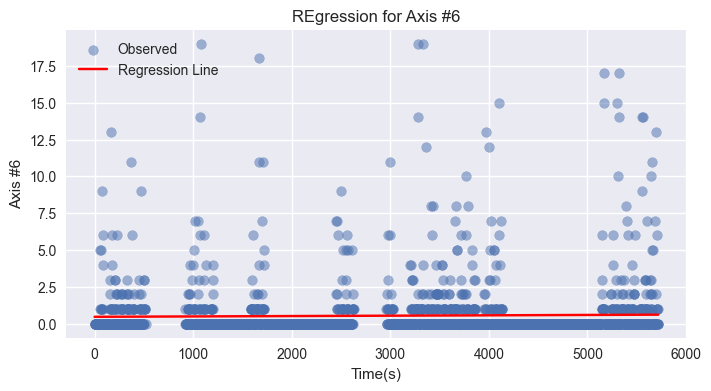

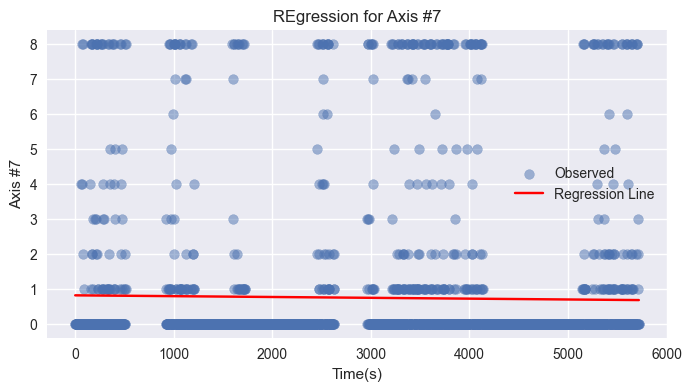

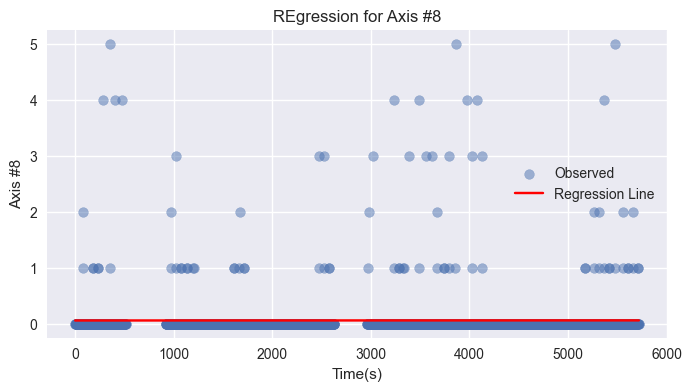

In [35]:
df_train["time_seconds"] = (df_train["Time"] - df_train["Time"].min()).dt.total_seconds()

models = {}
residuals = {}

for axis in axis_cols:
    x = df_train[["time_seconds"]].values
    y = df_train[axis].values

    model = LinearRegression().fit(x,y)
    y_pred = model.predict(x)

    models[axis] = model
    residuals[axis] = y - y_pred

    # Plot the regression

    plt.figure(figsize=(8,4))

    plt.scatter(df_train["time_seconds"], y, alpha=0.5, label="Observed")
    plt.plot(df_train["time_seconds"], y_pred, color="red", label="Regression Line")

    plt.title(f"REgression for {axis}")
    plt.xlabel("Time(s)")
    plt.ylabel(axis)
    plt.legend()
    plt.show()


Residual Analysis

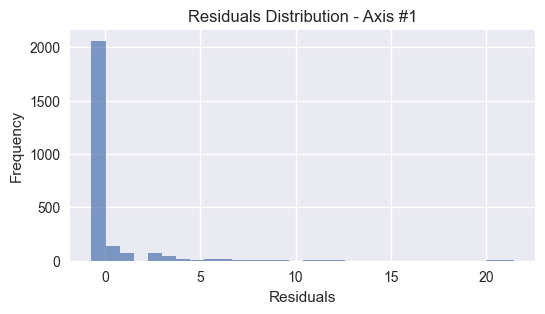

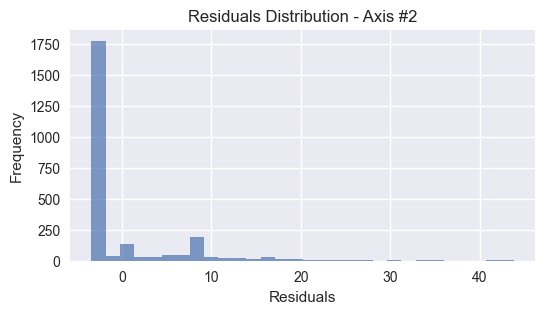

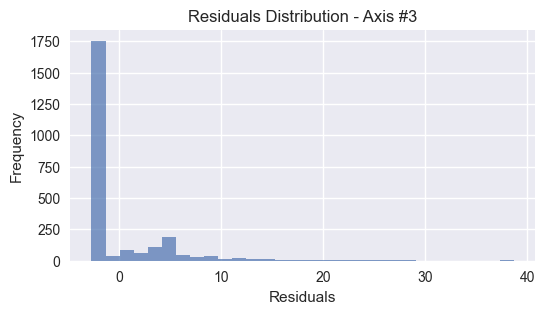

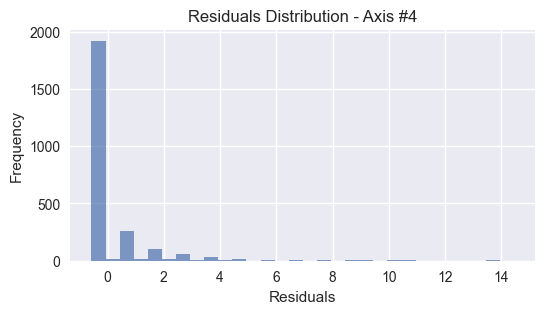

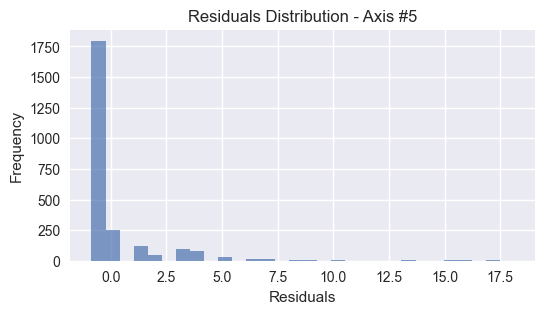

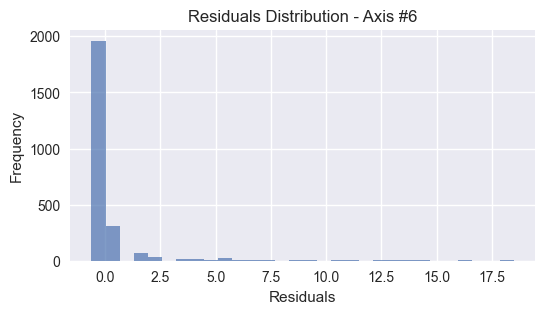

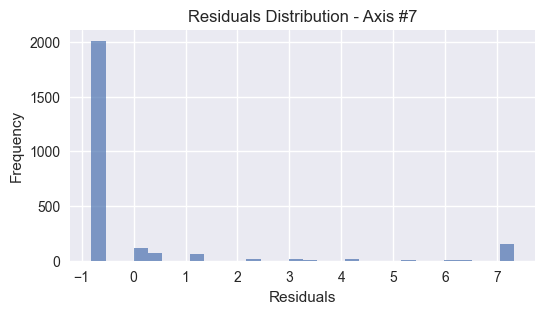

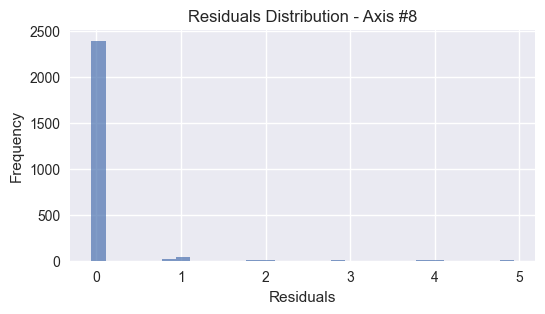

In [36]:
for axis in axis_cols:

    res = residuals[axis]
    plt.figure(figsize=(6,3))
    plt.hist(res, bins=30, alpha=0.7)
    plt.title(f"Residuals Distribution - {axis}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

Define Min Max

In [37]:
thresholds = {}

for axis in axis_cols:
    res = residuals[axis]

    minC = np.percentile(res, 90) # 90th percinetile deviation sends alert
    maxC = np.percentile(res, 95) # 95th percentile deviation sends error
    T = 5

    thresholds[axis] = {"MinC": minC, "MaxC": maxC, "T": T}

    thresholds

# Detect Alerts  & Errors

In [38]:

alerts = []

for axis in axis_cols:

    res = residuals[axis]
    MinC = thresholds[axis]["MinC"]
    MaxC = thresholds[axis]["MaxC"]
    T = thresholds[axis]["T"]


    above_min = df_train[res>MinC]
    above_max = df_train[res<MaxC]

    if not above_min.empty:
        alerts.append((axis, "ALERT", above_min[time_col].iloc[0]))
    if not above_max.empty:
        alerts.append((axis,"error", above_max[time_col].iloc[0]))


    pd.DataFrame(alerts, columns = ["Axis", "Type", "Time"])

# Save Results

In [39]:
# Local save to the results

pd.DataFrame.from_dict(thresholds, orient="index").to_csv("data/results_thresholds.csv")
pd.DataFrame(alerts, columns = ["Axis", "Type", "Time"]).to_csv("data/results_detected_events.csv", index=False)

# Explinatnion